## Fit a 2D model to the metallicity map of MACS1206

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='dark')

import numpy as np
from scipy.stats import binned_statistic

from astropy.io import fits
from reproject import reproject_interp
from astropy import cosmology as co
import astropy.units as uu
from astropy.stats import median_absolute_deviation
from astropy.convolution import convolve,Gaussian2DKernel
from astropy.stats import median_absolute_deviation, sigma_clipped_stats

import warnings
warnings.filterwarnings('ignore')

cd = co.FlatLambdaCDM(H0=70*uu.km/(uu.megaparsec * uu.s), Om0=0.3, Tcmb0 = 2.725*uu.K,\
                          Neff=3.05, m_nu=[0., 0., 0.06]*uu.eV, Ob0 = 0.0483)

Check how the distance map looks like in the arc

<IPython.core.display.Javascript object>


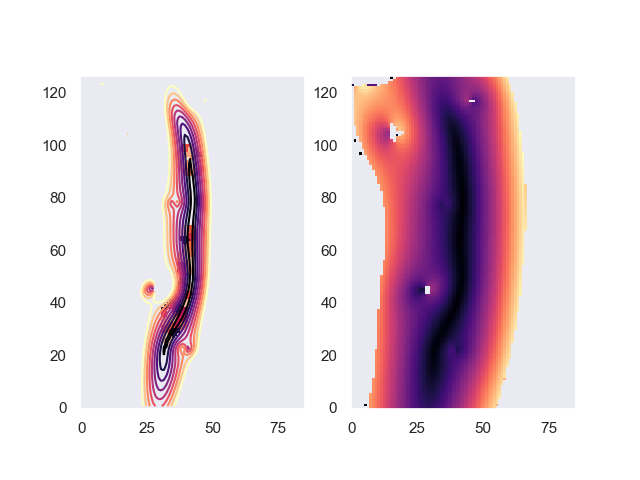

In [2]:
met_map = fits.getdata('Maps/Map_metallicity.fits')
emet_map = fits.getdata('Maps/Map_metallicity_unc.fits')
header = fits.getheader('Maps/Map_metallicity.fits')
dist_map, _ = reproject_interp('../../Data/Lensing/MACS1206/simul_MACS1206_distance_kpc_source_plane.fits',header) 
data_shape = met_map.shape

# distance map has lots of zeros and weird values at the borders. isolate those
# Calculate the difference between pixels along the x axis (for each y) in a simetrical
# way from the minimum value
diff_map = np.zeros_like(dist_map)
for y in range(dist_map.shape[0]):
    stripe = dist_map[y,:]
    centre = int(np.where(stripe[20:40] == np.min(stripe[20:40]))[0])
    right = stripe[:centre+20]
    left = stripe[centre+20:]
    diff_right = [right[x] - right[x-1] for x in range(len(right))]
    diff_left  = [left[x-1] - left[x] for x in range(len(left))]
    diff_map[y,:centre+20] = diff_right 
    diff_map[y,centre+20:] = diff_left

bad_pix = np.where(diff_map > 3)
dist_map[bad_pix] = np.nan
dist_map[np.where(dist_map==0.)] = np.nan

fig, ax = plt.subplots(1,2)
ax[0].imshow(met_map,origin='lower',)
ax[0].contour(dist_map,origin='lower',levels=range(10),cmap='magma')
ax[1].imshow(dist_map,origin='lower',cmap='magma')

Fit the slope and the intercept and taking the seeing into account

In [4]:
from lmfit import Parameters
import time
import pickle
import emcee
    
def bin_gradient_and_data(aligned_model,data,uncertainty,voronoi_map):
    """ Assumes the voronoi binning was done in the 'data' file.
    Returns a flat arrray of both the model and the data, corresponding to the same binning"""
    model_flt = []
    data_flt = []
    unc_flt = []
    for bin_nb in np.unique(voronoi_map):
        sel_pix = np.where(voronoi_map == bin_nb)    
        model_flt.append(np.nanmean(aligned_model[sel_pix]))
        data_flt.append(np.nanmean(data[sel_pix]))
        unc_flt.append(np.nanmean(uncertainty[sel_pix]))

    return np.array(model_flt),np.array(data_flt),np.array(unc_flt)

def fit_gradient_fixed_dist_map(data_path,uncertainty_path,dist_path,seeing_fwhm_pix,voronoi_path,parameters,max_radius):

    start_time = time.time()
    
    # Load data
    data = fits.getdata(data_path)
    data_header = fits.getheader(data_path)
    unc = fits.getdata(uncertainty_path)
    dist_map, _ = reproject_interp(dist_path,data_header)
    bad_pix = np.where((dist_map == 0.0))
    voronoi_map = fits.getdata(voronoi_path)

    # Check which parameters are varied
    parameter_names = [] # array because emcee varies it
    starting_point = []
    starting_low = []
    starting_high = []
    fixed_parameters = {} # dictionary
    for key in parameters.keys():
        if parameters[key].vary:
            parameter_names.append(key)
            starting_point.append(parameters[key].value)
            starting_high.append(parameters[key].max)
            starting_low.append(parameters[key].min)
        else:
            fixed_parameters[key] = parameters[key].value

    ndim = len(parameter_names)
    print('Fixed parameters: %s '%fixed_parameters)
    
    # Priors: uniform
    def lnprior(par):
        for par_value,par_name in zip(par,parameter_names):
            if par_value < parameters[par_name].min or par_value > parameters[par_name].max:
                return -np.inf
        return 0
    
    # Log likelihood function
    def lnprob(par,parameter_names,fixed_parameters):

        lp = lnprior(par)

        # this makes is slightly faster cause it avoids actually calculating stuff where the parameters are out of bounderies
        if lp == -np.inf: 
            return lp
        
        else:

            # Fill in parameters that are varied
            for par_value,par_name in zip(par,parameter_names): 
                if par_name == 'dexperkpc': 
                    dexperkpc = par_value
                elif par_name == 'peakmet':            
                    peakmet = par_value
                else:
                    print('Parameter name error: %s'%par_name)                    
                    
            # Add fixed parameters
            for k in fixed_parameters.keys():
                if k == 'dexperkpc': 
                    dexperkpc = fixed_parameters[k]
                elif k == 'peakmet': 
                    peakmet = fixed_parameters[k]
                else:
                    print('Fixed Parameter name error: %s'%k)

            # Create model    
            lensed_grad = dexperkpc * dist_map + peakmet
            convolved_grad = convolve(lensed_grad,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')

            # Compare with data
            binned_model, binned_data, binned_unc = bin_gradient_and_data(convolved_grad,data,unc,voronoi_map)
            inv_sigma2 = 1.0/(binned_unc**2)
            lnp = -0.5*(np.nansum((binned_data-binned_model)**2*inv_sigma2 - np.log(inv_sigma2*np.sqrt(2*np.pi))))

            return lnp + lp 
    
    # Prepare sampler
    nwalkers= 24
    print('Preparing sampler with %d walkers'%nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[parameter_names,fixed_parameters])
    p0 = [np.random.uniform(starting_low,starting_high) for i in range(nwalkers)]

    # Fitting
    nsteps = 1000
    print('MCMCing for %d steps'%nsteps)
    for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
        if i % 10 == 0:
            print("{0:5.1%}".format(float(i) / nsteps))

    with open("fixed_dist_map_fit_result.pickle",'wb') as f:
        results = {}
        results['chain'] = sampler.chain
        results['lnprobability'] = sampler.lnprobability
        results['fitted_parameters'] = parameter_names
        results['parameters'] = parameters
        pickle.dump(results,f)

    print('Execution time: %0.4f minutes'%(float(time.time() - start_time)/60))

In [5]:
import corner
import pickle
    
def check_convergence(pickle_file):

    res = pickle.load(open(pickle_file,'rb'))    

    print('Fitted parameters: %s'%res['fitted_parameters'])

    chain = res['chain']
    ln = res['lnprobability']
    nwalk = ln.shape[0]
    ndim = len(res['fitted_parameters'])


    fig1, ax = plt.subplots(1,ndim+1,figsize=(14,4))
    ax = ax.ravel()
    for j in range(nwalk):
        ax[0].plot(ln[j, :])
        ax[0].set_title('lnP')
    
    for i in range(ndim):
        for j in range(nwalk):
            ax[i+1].plot(chain[j, :, i])
            ax[i+1].set_title(res['fitted_parameters'][i])

    return fig1

def make_cornerplot(pickle_file,start):
    """ start: chain steps below this value are not included in the plot"""
   
    res = pickle.load(open(pickle_file,'rb'))

    chain = res['chain']
    ndim = len(res['fitted_parameters'])
    samples = chain[:, start:, :].reshape((-1, ndim))

    best_par = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))

    fig = corner.corner(samples, labels=res['fitted_parameters'],truths=np.array(best_par).T[0],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True)

    for n,v in zip(res['fitted_parameters'],best_par):
        print('%s %0.4f$^{+%0.4f}_{-%0.4f}$'%(n,v[0],v[1],v[2]))

    if len(res['fitted_parameters']) == 7:
        print('input to make_2d_plot')
        print('%0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f '
                %(best_par[0][0],best_par[1][0],best_par[2][0],best_par[3][0],best_par[4][0],best_par[5][0],best_par[6][0]))

    return fig

def plot_best_solution_fixed_dist_map(dexperkpc,peakmet,data_path,uncertainty_path,dist_path,voronoi_path,seeing_fwhm_pix,max_radius):
                                         
    # Load data
    data = fits.getdata(data_path)
    data_header = fits.getheader(data_path)
    unc = fits.getdata(uncertainty_path)
    voronoi_map = fits.getdata(voronoi_path)
    dist_map, _ = reproject_interp(dist_path,data_header)
    bad_pix = np.where((dist_map == 0.0))
    
                       
    lensed_grad = dist_map * dexperkpc + peakmet
    convolved_grad = convolve(lensed_grad,Gaussian2DKernel(seeing_fwhm_pix/2.355),boundary='extend')
    
    fig, ax = plt.subplots(1,5,figsize=(12,3))
    cax = ax[0].imshow(data,origin='lower')
    plt.colorbar(cax,ax=ax[0])
    cxa = ax[1].imshow(lensed_grad,origin='lower')
    plt.colorbar(cax,ax=ax[1])
    cxa = ax[2].imshow(convolved_grad,origin='lower')
    plt.colorbar(cax,ax=ax[2])
    cax = ax[3].imshow(data-lensed_grad,cmap='seismic',origin='lower')
    plt.colorbar(cax,ax=ax[3])
    cax = ax[4].imshow(data-convolved_grad,cmap='seismic',origin='lower')
    plt.colorbar(cax,ax=ax[4])
    t = [x.axis('off') for x in ax]
    
    #Stats
    free_par = 2
    binned_model, binned_data, binned_unc = bin_gradient_and_data(convolved_grad,data,unc,voronoi_map)
    chi2 = np.nansum((binned_data-binned_model)**2/binned_unc**2)
    inv_sigma2 = 1.0/(binned_unc**2)
    lnp = -0.5*(np.nansum((binned_data-binned_model)**2*inv_sigma2- np.log(inv_sigma2*np.sqrt(2*np.pi))))
    bic = free_par*np.log(len(binned_data)) - 2*lnp
    mad = median_absolute_deviation(binned_data-binned_model,ignore_nan=True)
    print('Chi2: %0.2f; Chi2/dof: %0.2f'%(chi2,chi2/(len(binned_data)-free_par)))
    print('Loglikelihood: %d; BIC: %d'%(lnp,bic))
    print('Median Absolute Deviation %0.6f'%mad)
    
    return lensed_grad,convolved_grad

Fitting the data

In [26]:
def define_parameters():
    """This has to be edited manually."""
    p = Parameters()
    p.add_many(
    #  (Name,               Value,  Vary, Min, Max)
       ("dexperkpc",        -0.0,  True, -0.2, 0.0),
       ("peakmet",           9.0,  True,  8.5, 9.5))
    return p
  
init_par = define_parameters()
header = fits.getheader('../../Data/HST/MACS1206_arc_F105w.fits')
physical_scale = abs(header['CDELT2']) * cd.kpc_proper_per_arcmin(1.033).to('kpc/deg').value


fit_gradient_fixed_dist_map(data_path= 'Maps/Map_metallicity.fits',
                            uncertainty_path = 'Maps/Map_metallicity_unc.fits',
                            dist_path = '../../Data/Lensing/MACS1206/simul_MACS1206_distance_kpc_source_plane.fits',
                            seeing_fwhm_pix = 0.78/0.12,
                            voronoi_path = 'Maps/Map_bins_SN_10_flux_stddev.fits',
                            parameters = init_par,
                            max_radius=100.)

Fixed parameters: {} 
Preparing sampler with 24 walkers
MCMCing for 1000 steps
 0.0%
 1.0%
 2.0%
 3.0%
 4.0%
 5.0%
 6.0%
 7.0%
 8.0%
 9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
Execution time: 7.5442 minutes


Fitted parameters: ['dexperkpc', 'peakmet']


<IPython.core.display.Javascript object>


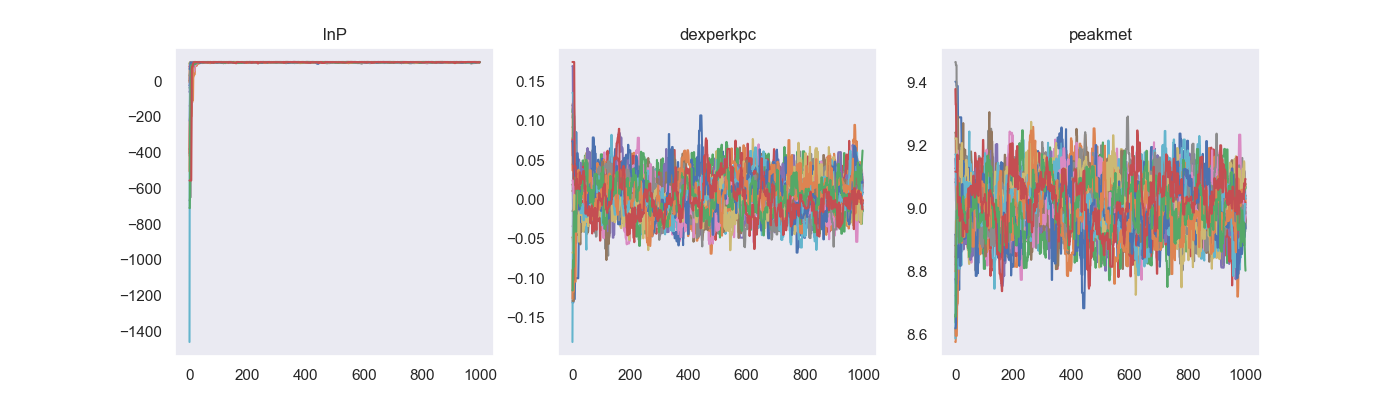

<IPython.core.display.Javascript object>


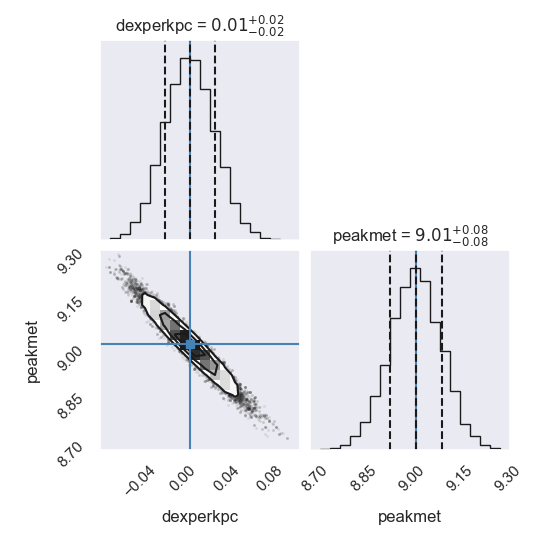

dexperkpc 0.0056$^{+0.0234}_{-0.0230}$
peakmet 9.0124$^{+0.0810}_{-0.0804}$


In [18]:
fig1 = check_convergence('fixed_dist_map_fit_result.pickle')
fig2 = make_cornerplot('fixed_dist_map_fit_result.pickle',100)

<IPython.core.display.Javascript object>


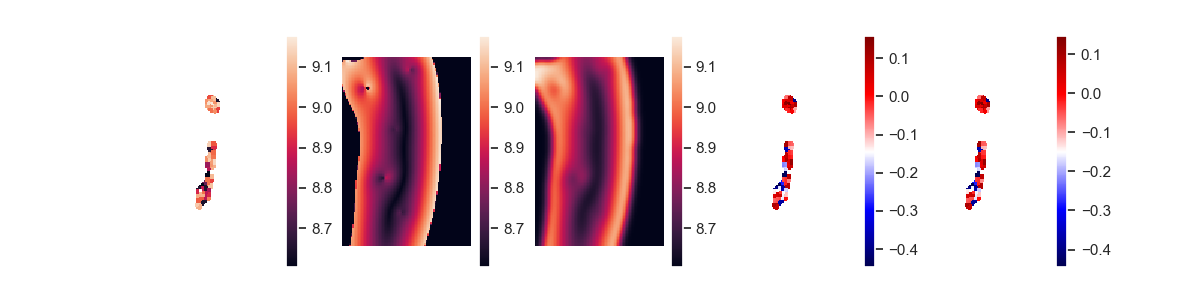

Chi2: 34.52; Chi2/dof: 0.59
Loglikelihood: 114; BIC: -220
Median Absolute Deviation 0.089507


In [19]:
lensed_grad,convolved_grad = \
        plot_best_solution_fixed_dist_map(dexperkpc = 0.0056,peakmet = 9.0124,
                                          data_path = 'Maps/Map_metallicity.fits',
                                          uncertainty_path = 'Maps/Map_metallicity_unc.fits',
                                          dist_path = '../../Data/Lensing/MACS1206/simul_MACS1206_distance_kpc_source_plane.fits',
                                          voronoi_path = 'Maps/Map_bins_SN_10_flux_stddev.fits',
                                          seeing_fwhm_pix = 0.78/0.12, 
                                          max_radius = 100.)

## Plotting

multi-region file (manually)

In [20]:
met_map = fits.getdata('Maps/Map_metallicity.fits')
emet_map = fits.getdata('Maps/Map_metallicity_unc.fits')
voronoi_map = fits.getdata('Maps/Map_bins_SN_10_flux_stddev.fits')
header = fits.getheader('Maps/Map_metallicity.fits')
#mult_map, _ = reproject_interp('mult_region_mask.fits',header)
dist_map,_ = reproject_interp('../../Data/Lensing/MACS1206/simul_MACS1206_distance_kpc_source_plane.fits',header)
dist_map[np.where(dist_map==0)] = np.nan
res_map = met_map - convolved_grad

<IPython.core.display.Javascript object>


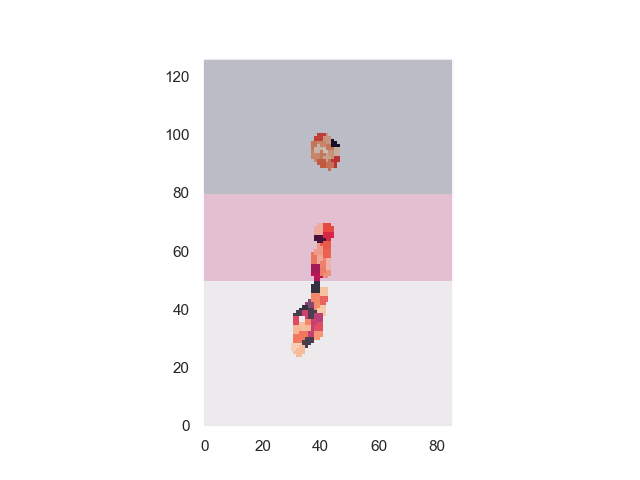

In [22]:
mult_map = met_map.copy()
mult_map[80:-1,:] = 1
mult_map[50:80,:] = 2
mult_map[0:50,:] = 3

plt.figure()
plt.imshow(met_map,origin='lower')
plt.imshow(mult_map,alpha=0.2,origin='lower')

In [23]:
voronoi_map[np.where(voronoi_map==-1)] = np.nan
bins = np.unique(voronoi_map)
bins = bins[~np.isnan(bins)]

def measure_in_vbins(im,stat):
    if stat == 'mean':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[0] for v in bins ])
    if stat == 'std':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[2] for v in bins ])

# Metallicity
met_vbin     = measure_in_vbins(met_map,'mean')
emet_vbin    = measure_in_vbins(emet_map,'mean')
met_vbin_std = measure_in_vbins(met_map,'std') 
met_vbin_err = np.sqrt(emet_vbin**2 + met_vbin_std**2)

# Model
model_vbin     = measure_in_vbins(convolved_grad,'mean')
model_vbin_std = measure_in_vbins(convolved_grad,'std')

# Residuals
res_vbin = measure_in_vbins(res_map,'mean') 

# Morphology
dist_vbin     = measure_in_vbins(dist_map,'mean')
dist_vbin_std = measure_in_vbins(dist_map,'std')

size_vbin   = np.array([len(np.atleast_1d(np.where(voronoi_map==v)[0])) for v in bins ])
reg_vbin = np.array([sigma_clipped_stats(mult_map[np.where(voronoi_map==v)])[0] for v in np.unique(voronoi_map) ])[1:]

In [24]:
def bin_data_r(data):
    good_pix = np.where(np.isfinite(data))
    binned_data, bin_edges, bin_number = binned_statistic(dist_vbin[good_pix],data[good_pix],'mean',bins=range(0,18))
    binned_err, bin_edges, bin_number = binned_statistic(dist_vbin[good_pix],data[good_pix],'std',bins=range(0,18))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return binned_data, binned_err, bin_centers

<IPython.core.display.Javascript object>


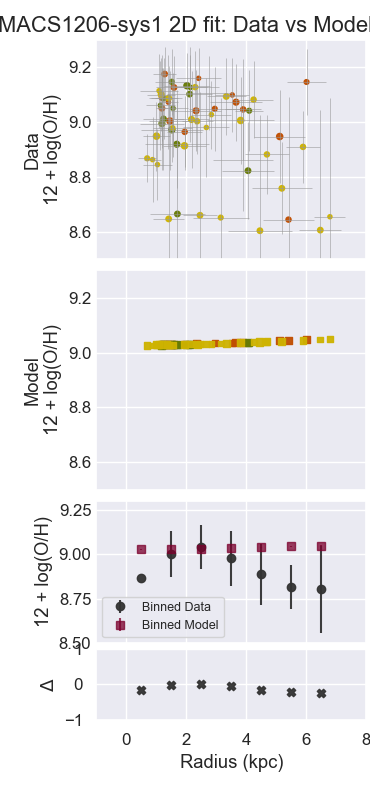

('MAD radial ', 0.09153946570946303)


In [25]:
# Set plotting style
sns.set_style('darkgrid')
sns.set(font_scale=1.1)
c_reg1,c_reg2,c_reg3 = '#c04e01','#677a04','#ceb301'

## Set figure
fig, ax = plt.subplots(3,1,figsize=(3.7,8))
fig.suptitle('MACS1206-sys1 2D fit: Data vs Model')
fig.subplots_adjust(top=0.95,left=0.26,right=0.99,wspace=0.02,hspace=0.05,bottom=0.1)
gs4 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax[2],height_ratios=[2,1])
gs40 = plt.Subplot(fig, gs4[0])
fig.add_subplot(gs40)
gs41 = plt.Subplot(fig, gs4[1])
fig.add_subplot(gs41)
ax[2].axis('off')

## Axis and labels
ax[0].set_ylim(8.5,9.3)
ax[1].set_ylim(8.5,9.3)
gs40.set_ylim(8.5,9.3)
gs41.set_ylim(-1,1)

ax[0].set_xlim(-1,8)
ax[1].set_xlim(-1,8)
gs40.set_xlim(-1,8)
gs41.set_xlim(-1,8)


ax[0].set_ylabel('Data\n12 + log(O/H)')
ax[1].set_ylabel('Model\n12 + log(O/H)')
gs40.set_ylabel('12 + log(O/H)')
gs41.set_ylabel('$\Delta$')
gs41.set_xlabel('Radius (kpc)')

ax[0].tick_params(labelbottom=False,direction='in')    
ax[1].tick_params(labelbottom=False,direction='in')  
gs40.tick_params(labelbottom=False,direction='in') 

## Radial data and model
ax[0].errorbar(dist_vbin, met_vbin, xerr=dist_vbin_std, yerr=met_vbin_err, linestyle='', ecolor='0.6', elinewidth=0.4)
for c,region,l in zip((c_reg1,c_reg2,c_reg3),range(1,5),('head','reg. 1','reg. 2','reg. 3')):
    pix = np.where(reg_vbin==region)
    ax[0].scatter(dist_vbin[pix],met_vbin[pix],linewidths=None,alpha=0.95,marker='.',color=c,s=size_vbin**1.7+20,label=l)
    ax[1].scatter(dist_vbin[pix],model_vbin[pix],linewidths=None,alpha=0.95,marker='s',c=c,s=size_vbin**1.2+10)
#ax[0].scatter(dist_vbin, met_vbin, linewidths=None, alpha=0.95, marker='.', s=size_vbin**2+35)
#ax[1].scatter(dist_vbin, model_vbin, linewidths=None, alpha=0.95, marker='s', s=size_vbin**1.3+10)

# Radial residuals
met_rbin, met_std_rbin, dist_rbin = bin_data_r(met_vbin)
model_rbin, model_std_rbin, dist_rbin = bin_data_r(model_vbin)
res_rbin = met_rbin - model_rbin
gs40.errorbar(dist_rbin, met_rbin, yerr=met_std_rbin, linestyle='', alpha=0.95, marker='o',color='0.2',label='Binned Data')
gs40.errorbar(dist_rbin, model_rbin, yerr=model_std_rbin, linestyle='', alpha=0.75, marker='s',color='#7b002c',label='Binned Model')
gs41.scatter(dist_rbin, res_rbin, linewidths=None, alpha=0.95, marker='X',color='0.2',label='Residuals')
gs40.legend(fontsize=9,loc=3)

print('MAD radial ',median_absolute_deviation(res_rbin,ignore_nan=True))

fig.savefig('../../Plots/MACS1206_2Dfit.pdf')

Eliminate the lower metallicity points

(array([27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 37, 37, 38, 38, 38, 38,
       38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42,
       42, 43, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 63, 63, 64, 64,
       64, 64, 65, 65, 65, 96, 96, 96, 97, 97, 98]), array([35, 34, 35, 36, 34, 35, 36, 37, 35, 36, 37, 36, 37, 31, 32, 33, 36,
       37, 32, 33, 36, 37, 38, 33, 34, 35, 36, 37, 34, 35, 36, 37, 35, 36,
       37, 36, 37, 38, 39, 37, 38, 39, 37, 38, 39, 38, 39, 39, 40, 38, 39,
       40, 41, 38, 39, 40, 44, 45, 46, 44, 45, 44]))


<IPython.core.display.Javascript object>


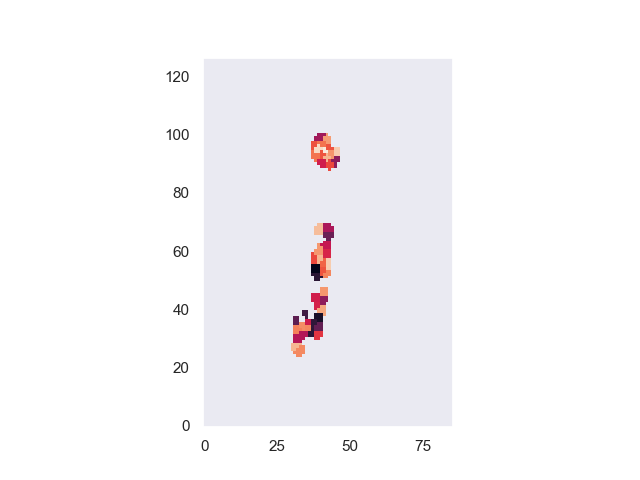

In [16]:
test = met_map.copy()
test[np.where(met_map<8.8)] = np.nan
print(np.where(met_map<8.8))

plt.figure()
plt.imshow(test,origin='lower')

fits.writeto('met_map_masked.fits',test,header)

In [17]:
def define_parameters():
    """This has to be edited manually."""
    p = Parameters()
    p.add_many(
    #  (Name,               Value,  Vary, Min, Max)
       ("dexperkpc",        -0.0,  True, -0.2, 0.2),
       ("peakmet",           9.0,  True,  8.5, 9.5))
    return p
  
init_par = define_parameters()
header = fits.getheader('../../Data/HST/MACS1206_arc_F105w.fits')
physical_scale = abs(header['CDELT2']) * cd.kpc_proper_per_arcmin(1.033).to('kpc/deg').value


fit_gradient_fixed_dist_map(data_path= 'met_map_masked.fits',
                            uncertainty_path = 'Maps/Map_metallicity_unc.fits',
                            dist_path = '../../Data/Lensing/MACS1206/simul_MACS1206_distance_kpc_source_plane.fits',
                            seeing_fwhm_pix = 0.78/0.12,
                            voronoi_path = 'Maps/Map_bins_SN_10_flux_stddev.fits',
                            parameters = init_par,
                            max_radius=100.)

Fixed parameters: {} 
Preparing sampler with 24 walkers
MCMCing for 1000 steps
 0.0%
 1.0%
 2.0%
 3.0%
 4.0%
 5.0%
 6.0%
 7.0%
 8.0%
 9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
Execution time: 7.4241 minutes


## Full fit in image plane, including changing ellipticity and centre

In [13]:
from astropy.wcs import WCS

def lensed_gradient(dexperkpc,peakmet,cx,cy,ellip,theta,data_shape,sxmodel,symodel,max_radius):
    ''' Makes a gradient in source plane and leses it back to image plane.
    Parameters:
    -----------
    dexperkpc: float
        slope of the gradient in dex/kpc
    peakmet: float
        central metallicity value
    data_wcs: astropy.wcs
        WCS object from data (to align displacement maps)
    dplx,dply: 2d array
        displacement maps (from lenstool)
    dpl_header: astropy.header
        header of the displacement maps (doesn't matter which, if they are aligned, which they should)
    cx,cy: int
        center of the gradient in image plane
    ellip: float
        ellipticity, defined as in astropy
    theta: float
        position angle, defined as in astropy
    kpcperpix: float
        kpc per pixel in the data image
    Output:
    -------
    2d array (gradient in image plane)
    '''
    
    def centre_displacement_map(sxmodel,symodel,cx,cy):        
        center_x = sxmodel[int(cy),int(cx)] 
        center_y = symodel[int(cy),int(cx)] 
        centered_sx = (sxmodel - center_x)
        centered_sy = (symodel - center_y)
        return centered_sx, centered_sy

    lensmodelx, lensmodely = centre_displacement_map(sxmodel,symodel,cx,cy)
    
    # Create 2D model
    y_ip,x_ip = np.mgrid[:data_shape[0], :data_shape[1]]
    x_all = lensmodelx[y_ip,x_ip]
    y_all = lensmodely[y_ip,x_ip]
    
    # include rotation
    x_rot = x_all*np.cos(theta)+y_all*np.sin(theta) 
    y_rot = y_all*np.cos(theta)-x_all*np.sin(theta)
    i = np.arccos(1-ellip)
    dist = np.sqrt((x_rot)**2+((y_rot)/np.cos(i))**2)
    
    bad_pix = np.where(dist > max_radius)
        
    return dist * dexperkpc + peakmet, bad_pix

In [14]:
from lmfit import Parameters
import time
import pickle
import emcee

def fit_gradient(data_path,uncertainty_path,dplx_path,dply_path,z,seeing_fwhm_pix,voronoi_path,parameters,max_radius,nsteps,outputname):

    start_time = time.time()
    
    # Load data
    data = fits.getdata(data_path)
    data_header = fits.getheader(data_path)
    data_shape = data.shape
    unc = fits.getdata(uncertainty_path)
    dplx = fits.getdata(dplx_path)
    dply = fits.getdata(dply_path)
    dpl_header = fits.getheader(dplx_path)
    voronoi_map = fits.getdata(voronoi_path)
    
    # Massage displacement maps
    step = abs(dpl_header['CDELT2'])*3600.0
    sx = -1.0*dplx
    sy = -1.0*dply
    X,Y = np.meshgrid(xrange(dplx.shape[0]),xrange(dplx.shape[1]))
    sx += X*step
    sy += Y*step
    sxmodel, _ = reproject_interp((sx,dpl_header),data_header) # these are the displacements in arcsec
    symodel, _ = reproject_interp((sy,dpl_header),data_header)
    sxmodel = sxmodel/cd.arcsec_per_kpc_proper(z).value
    symodel = symodel/cd.arcsec_per_kpc_proper(z).value
    
    # Check which parameters are varied
    parameter_names = [] # array because emcee varies it
    starting_point = []
    starting_low = []
    starting_high = []
    fixed_parameters = {} # dictionary
    for key in parameters.keys():
        if parameters[key].vary:
            parameter_names.append(key)
            starting_point.append(parameters[key].value)
            starting_high.append(parameters[key].max)
            starting_low.append(parameters[key].min)
        else:
            fixed_parameters[key] = parameters[key].value

    ndim = len(parameter_names)
    print('Fixed parameters: %s '%fixed_parameters)
    
    # Priors: uniform
    def lnprior(par):
        for par_value,par_name in zip(par,parameter_names):
            if par_value < parameters[par_name].min or par_value > parameters[par_name].max:
                return -np.inf
        return 0
    
    # Log likelihood function
    def lnprob(par,parameter_names,fixed_parameters):
        
        lp = lnprior(par)

        # this makes is slightly faster cause it avoids actually calculating stuff where the parameters are out of bounderies
        if lp == -np.inf: 
            return lp
        
        else:
            # Fill in parameters that are varied
            for par_value,par_name in zip(par,parameter_names): 
                if par_name == 'dexperkpc': 
                    dexperkpc = par_value
                elif par_name == 'peakmet':            
                    peakmet = par_value
                elif par_name == 'cx':            
                    cx = par_value
                elif par_name == 'cy':            
                    cy = par_value
                elif par_name == 'ellip':            
                    ellip = par_value
                elif par_name == 'theta':            
                    theta = par_value
                else:
                    print('Parameter name error: %s'%par_name)                    
                    
            # Add fixed parameters
            for k in fixed_parameters.keys():
                if k == 'dexperkpc': 
                    dexperkpc = fixed_parameters[k]
                elif k == 'peakmet': 
                    peakmet = fixed_parameters[k]
                elif k == 'cx': 
                    cx = fixed_parameters[k]
                elif k == 'cy': 
                    cy = fixed_parameters[k]
                elif k == 'ellip': 
                    ellip = fixed_parameters[k]
                elif k == 'theta': 
                    theta = fixed_parameters[k]
                else:
                    print('Fixed Parameter name error: %s'%k)

            # Create model 
            lensed_grad,bad_pix = lensed_gradient(dexperkpc,peakmet,cx,cy,ellip,theta,data_shape,sxmodel,symodel,max_radius)      
            convolved_grad = convolve_gradient_with_seeing(lensed_grad,seeing_fwhm_pix)
            convolved_grad[bad_pix] = np.nan
            binned_model, binned_data, binned_unc = bin_gradient_and_data(convolved_grad,data,unc,voronoi_map)

            # Compare with data
            inv_sigma2 = 1.0/(binned_unc**2)
            lnp = -0.5*(np.nansum((binned_data-binned_model)**2*inv_sigma2- np.log(inv_sigma2*np.sqrt(2*np.pi))))
       
            return lnp + lp 
    
    # Prepare sampler
    nwalkers= 20
    print('Preparing sampler with %d walkers'%nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[parameter_names,fixed_parameters])
    p0 = [np.random.uniform(starting_low,starting_high) for i in range(nwalkers)]

    # Fitting
    nsteps = nsteps
    print('MCMCing for %d steps'%nsteps)

    for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
        if i % 50 == 0:
            print("{0:5.1%}".format(float(i) / nsteps))

    with open(outputname+".pickle",'wb') as f:
        results = {}
        results['chain'] = sampler.chain
        results['lnprobability'] = sampler.lnprobability
        results['fitted_parameters'] = parameter_names
        results['parameters'] = parameters
        pickle.dump(results,f)

    print('Execution time: %0.4f minutes'%(float(time.time() - start_time)/60))

In [15]:
def plot_best_solution(dexperkpc,peakmet,cx,cy,ellip,theta,data_path,uncertainty_path,dplx_path,dply_path,voronoi_path,seeing_fwhm_pix,z,max_radius):
     
    # Load data
    data = fits.getdata(data_path)
    data_header = fits.getheader(data_path)
    data_shape = data.shape
    unc = fits.getdata(uncertainty_path)
    dplx = fits.getdata(dplx_path)
    dply = fits.getdata(dply_path)
    dpl_header = fits.getheader(dplx_path)
    voronoi_map = fits.getdata(voronoi_path)
    
    # Massage displacement maps
    step = abs(dpl_header['CDELT2'])*3600.0
    sx = -1.0*dplx
    sy = -1.0*dply
    X,Y = np.meshgrid(xrange(dplx.shape[0]),xrange(dplx.shape[1]))
    sx += X*step
    sy += Y*step
    sxmodel, _ = reproject_interp((sx,dpl_header),data_header) # these are the displacements in arcsec
    symodel, _ = reproject_interp((sy,dpl_header),data_header)
    sxmodel = sxmodel/cd.arcsec_per_kpc_proper(z).value
    symodel = symodel/cd.arcsec_per_kpc_proper(z).value 
    
    lensed_grad = lensed_gradient(dexperkpc,peakmet,cx,cy,ellip,theta,data_shape,sxmodel,symodel,max_radius)  
    convolved_grad = convolve_gradient_with_seeing(lensed_grad,seeing_fwhm_pix)
    
    fig, ax = plt.subplots(1,5,figsize=(12,3))
    ax[0].set_title('Data')
    cax = ax[0].imshow(data,origin='lower')
    plt.colorbar(cax,ax=ax[0],fraction=0.05)
    ax[0].plot(cx,cy,marker='x',color='r')
    
    ax[1].set_title('Lensed Gradient')
    cxa = ax[1].imshow(lensed_grad,origin='lower',vmin=8.5)
    plt.colorbar(cax,ax=ax[1],fraction=0.05)
    
    ax[2].set_title('Convolved Gradient')
    cxa = ax[2].imshow(convolved_grad,origin='lower',vmin=8.5)
    plt.colorbar(cax,ax=ax[2],fraction=0.05)
    
    ax[3].set_title('Data - Lensed')
    cax = ax[3].imshow(data-lensed_grad,cmap='seismic',origin='lower')
    plt.colorbar(cax,ax=ax[3],fraction=0.05)
    
    ax[4].set_title('Data - Convolved')
    cax = ax[4].imshow(data-convolved_grad,cmap='seismic',origin='lower')
    plt.colorbar(cax,ax=ax[4],fraction=0.05)
    
    t = [x.axis('off') for x in ax]
    
    #Stats
    binned_model, binned_data, binned_unc = bin_gradient_and_data(convolved_grad,data,unc,voronoi_map)
    chi2 = np.nansum((binned_data-binned_model)**2/binned_unc**2)
    inv_sigma2 = 1.0/(binned_unc**2)
    lnp = -0.5*(np.nansum((binned_data-binned_model)**2*inv_sigma2- np.log(inv_sigma2*np.sqrt(2*np.pi))))
    mad = median_absolute_deviation(binned_data-binned_model,ignore_nan=True)
    
    print('Chi2: %0.2f; Chi2/dof: %0.2f'%(chi2,chi2/len(binned_data)))
    print('Loglikelihood: %0.2f'%lnp)
    print('Median Absolute Deviation %0.2f'%mad)
    
    return lensed_grad,convolved_grad

In [16]:
def prepare_displacement_maps(dplx_path,dply_path,data_path,z):
    
    data_header = fits.getheader(data_path)
    dplx = fits.getdata(dplx_path)
    dply = fits.getdata(dply_path)
    dpl_header = fits.getheader(dplx_path)
    
    step = abs(dpl_header['CDELT2'])*3600.0
    sx = -1.0*dplx
    sy = -1.0*dply
    X,Y = np.meshgrid(xrange(dplx.shape[0]),xrange(dplx.shape[1]))
    sx += X*step
    sy += Y*step
    sxmodel, _ = reproject_interp((sx,dpl_header),data_header) # these are the displacements in arcsec
    symodel, _ = reproject_interp((sy,dpl_header),data_header)
    sxmodel = sxmodel/cd.arcsec_per_kpc_proper(z).value
    symodel = symodel/cd.arcsec_per_kpc_proper(z).value
    
    return sxmodel,symodel

<IPython.core.display.Javascript object>


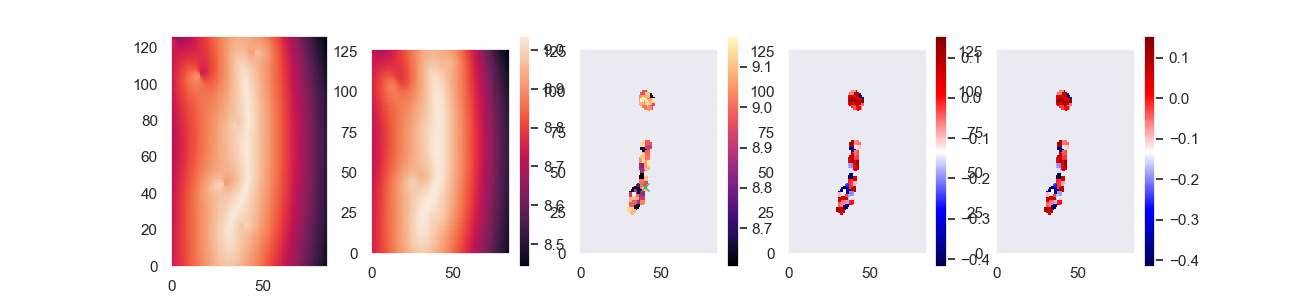

('center', (array([94, 94, 95]), array([41, 42, 41])))
central value 9.18


In [70]:
sxmodel, symodel = prepare_displacement_maps('../../Data/Lensing/MACS1206/MACS1206_dplx.fits',
                                             '../../Data/Lensing/MACS1206/MACS1206_dply.fits',
                                             'Maps/Map_metallicity.fits', z = 1.033)

lensed_grad, bad_pix = lensed_gradient(dexperkpc=-0.01,peakmet=9.05,cx=40,cy=41,ellip=0.5,theta=np.pi*4/6,
                              data_shape=data_shape,sxmodel=sxmodel,symodel=symodel,max_radius=100)  

convolved_grad = convolve_gradient_with_seeing(lensed_grad,seeing_fwhm_pix=1.03/0.2)

fig, ax = plt.subplots(1,5,figsize=(13,3))
ax[0].imshow(lensed_grad,origin='lower')

cax  = ax[1].imshow(convolved_grad,origin='lower')
plt.colorbar(cax,ax=ax[1])

cax = ax[2].imshow(met_map,origin='lower',cmap='magma')
ax[2].plot(40,41,marker='x',color='g')
plt.colorbar(cax,ax=ax[2])

cax=ax[3].imshow(met_map-lensed_grad,origin='lower',cmap='seismic')
plt.colorbar(cax,ax=ax[3])

cax=ax[4].imshow(met_map-convolved_grad,origin='lower',cmap='seismic')
plt.colorbar(cax,ax=ax[4])

# center
print('center',np.where(met_map == np.nanmax(met_map)))
print('central value %0.2f'%(np.nanmax(met_map)))

In [75]:
def define_parameters():
    """This has to be edited manually."""
    p = Parameters()
    p.add_many(
    #  (Name,               Value,  Vary,    Min,     Max)
       ("dexperkpc",       -0.02,   True,   -0.1,    0.05),
       ("peakmet",           9.0,   True,    8.5,     9.5),
       ("cx",                 40,   True,    38,     42.),
       ("cy",                 40,   True,    38,     42.),
       ("ellip",             0.5,   False,    0.2,     0.8),
       ("theta",       np.pi*4/6,   False,   np.pi*3/6  , np.pi*5/6))
    return p
  
    
init_par = define_parameters()

fit_gradient(data_path= 'Maps/Map_metallicity.fits',
             uncertainty_path = 'Maps/Map_metallicity_unc.fits',
             dplx_path = '../../Data/Lensing/MACS1206/MACS1206_dplx.fits',
             dply_path = '../../Data/Lensing/MACS1206/MACS1206_dply.fits',
             z = 1.033 , seeing_fwhm_pix = 0.7/0.12,
             voronoi_path = 'Maps/Map_bins_SN_10_flux_stddev.fits',
             parameters = init_par,max_radius= 100,
             nsteps=2000,outputname = 'fixed_ellip_and_theta_r100')

Fixed parameters: {'theta': 2.0943951023931953, 'ellip': 0.5} 
Preparing sampler with 20 walkers
MCMCing for 2000 steps
 0.0%
 2.5%
 5.0%
 7.5%
10.0%
12.5%
15.0%
17.5%
20.0%
22.5%
25.0%
27.5%
30.0%
32.5%
35.0%
37.5%
40.0%
42.5%
45.0%
47.5%
50.0%
52.5%
55.0%
57.5%
60.0%
62.5%
65.0%
67.5%
70.0%
72.5%
75.0%
77.5%
80.0%
82.5%
85.0%
87.5%
90.0%
92.5%
95.0%
97.5%
Execution time: 9.4485 minutes


Fitted parameters: ['dexperkpc', 'peakmet', 'cx', 'cy']


<IPython.core.display.Javascript object>


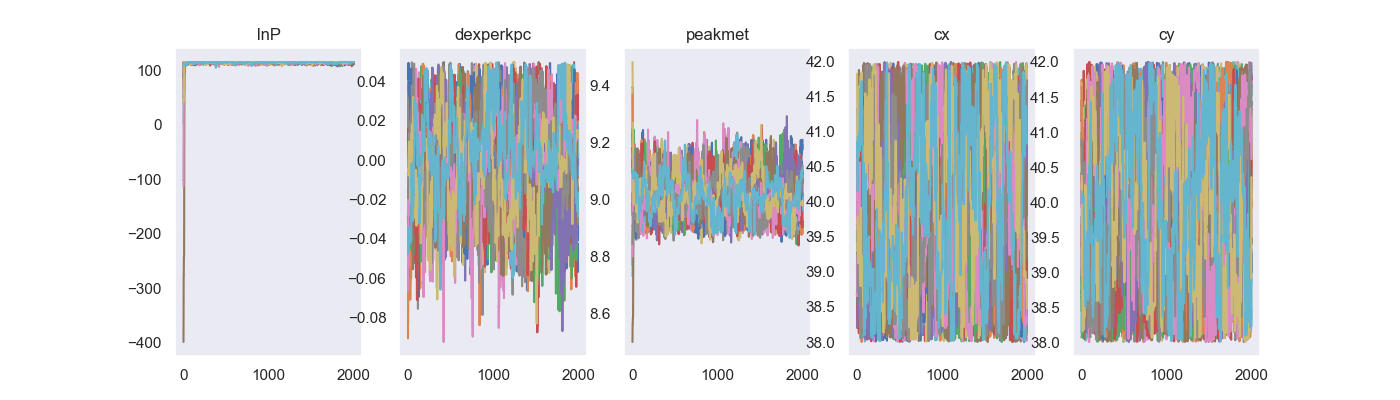

<IPython.core.display.Javascript object>


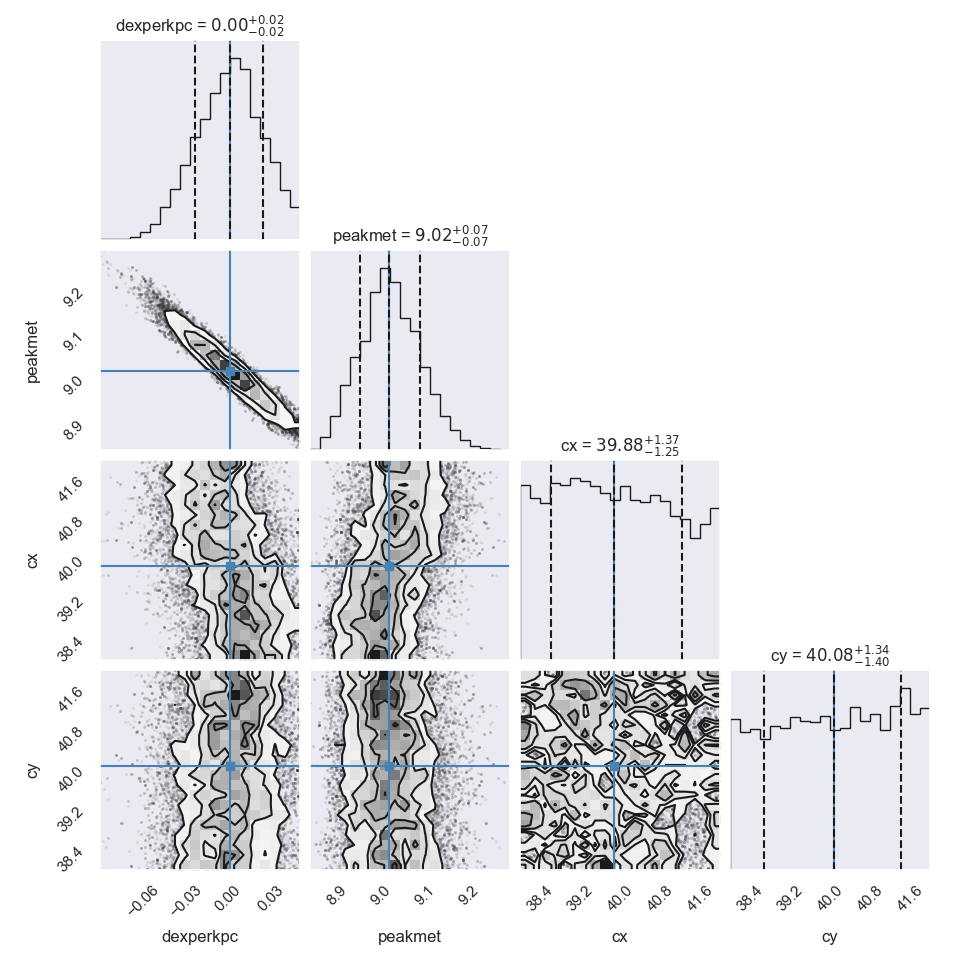

dexperkpc 0.0013$^{+0.0225}_{-0.0247}$
peakmet 9.0191$^{+0.0707}_{-0.0666}$
cx 39.8805$^{+1.3684}_{-1.2518}$
cy 40.0787$^{+1.3361}_{-1.3985}$


In [76]:
fig1 = check_convergence('fixed_ellip_and_theta_r100.pickle')
fig2 = make_cornerplot('fixed_ellip_and_theta_r100.pickle',500)

<IPython.core.display.Javascript object>


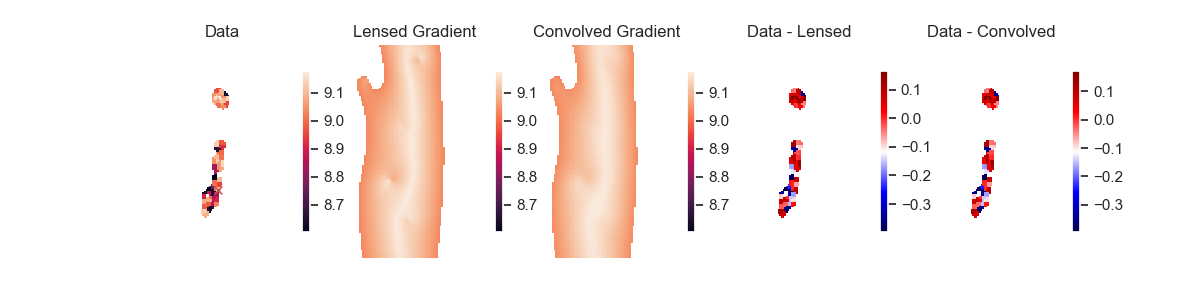

Chi2: 35.08; Chi2/dof: 0.58
Loglikelihood: 114.17
Median Absolute Deviation 0.09


In [84]:
lens,conv = plot_best_solution(dexperkpc= -0.0013 ,peakmet = 9.0191, cx = 40 ,cy = 40 ,ellip = 0.9 ,theta = np.pi*4/6 ,
                           data_path= 'Maps/Map_metallicity.fits',
                           uncertainty_path = 'Maps/Map_metallicity_unc.fits',
                           dplx_path = '../../Data/Lensing/MACS1206/MACS1206_dplx.fits',
                           dply_path = '../../Data/Lensing/MACS1206/MACS1206_dply.fits',
                           z = 1.033 , seeing_fwhm_pix = 0.7/0.12,max_radius=100,
                           voronoi_path = 'Maps/Map_bins_SN_10_flux_stddev.fits')

**The quality of the data is not enough to be able to do this kind of modelling**